In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from matplotlib import ticker as mpl

from scipy.optimize import linprog
import pulp as pl

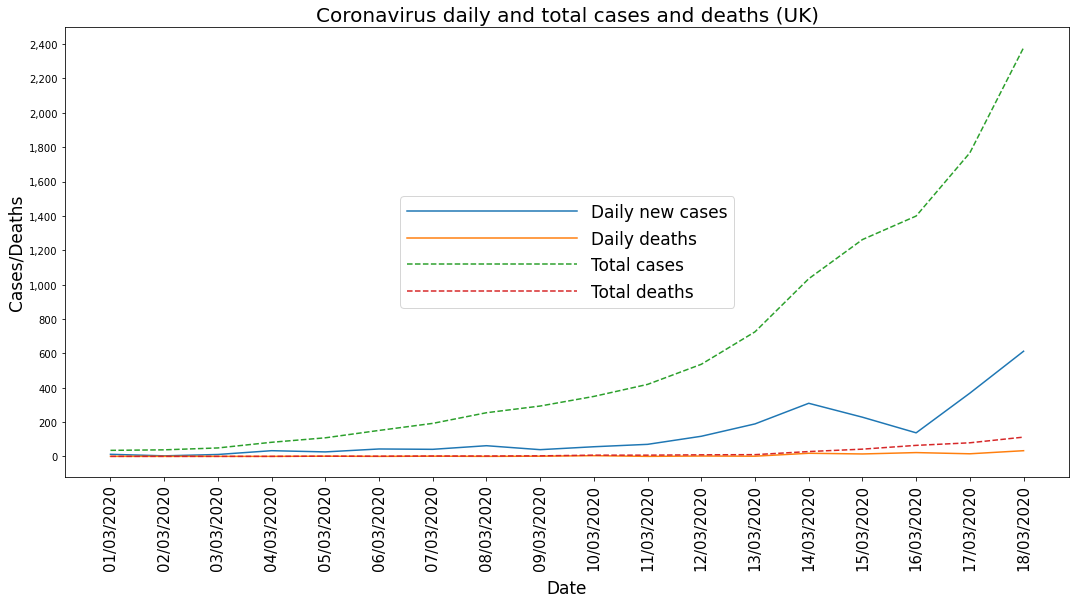

In [2]:
# plot graph with daily/total cases/deaths

covid = pd.read_csv("covid_data.csv")

a4_dims = (18, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(x=covid["date"],y=covid['daily new cases'],ci=None, ax=ax, label='Daily new cases')
sns.lineplot(x=covid["date"],y=covid['daily deaths'],ci=None, ax=ax, label='Daily deaths')
sns.lineplot(x=covid["date"],y=covid['total coronavirus cases'],ci=None, ax=ax, label='Total cases',linestyle="dashed")
sns.lineplot(x=covid["date"],y=covid['total deaths'],ci=None, ax=ax, label='Total deaths',linestyle="dashed")

ax.tick_params(axis='x', rotation=90, labelsize=15)
ax.set_xlabel("Date", fontsize=17,labelpad=9)

plt.yticks(np.arange(0, max(covid['total coronavirus cases'])+100, 200))
ax.yaxis.set_major_formatter(mpl.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("Cases/Deaths", fontsize=17)

ax.set_title("Coronavirus daily and total cases and deaths (UK)", fontsize=20)
do_not_print = plt.legend(loc='center',fontsize='17',handlelength=10)

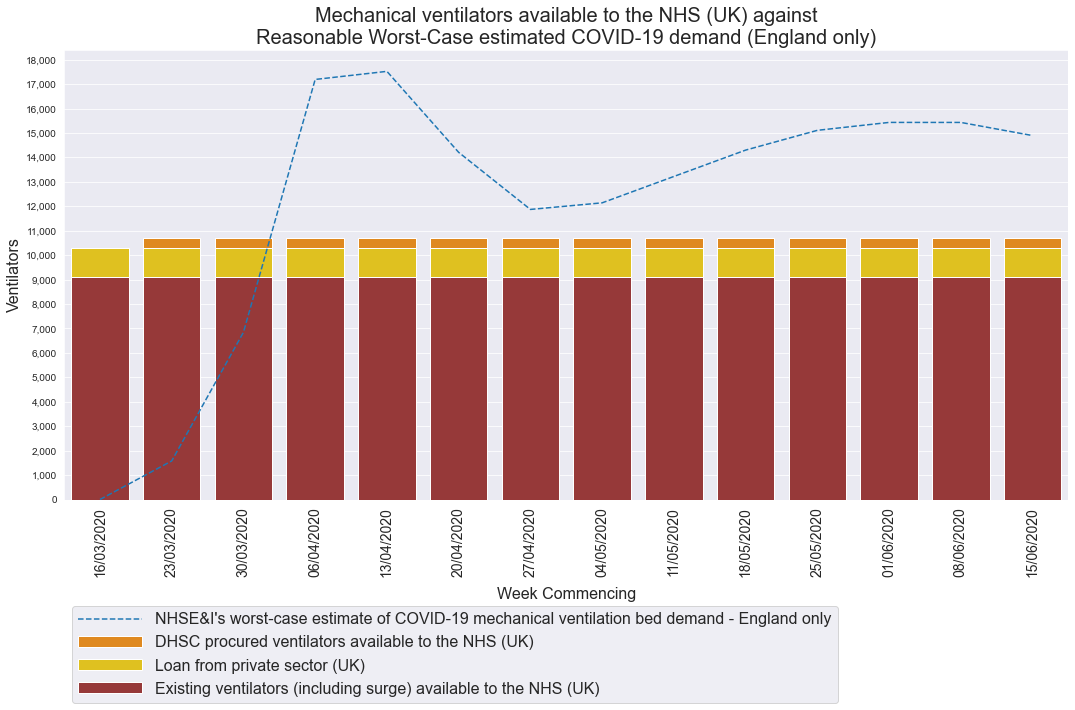

In [3]:
# plot graph showing estimated mechanical ventilator demand

sns.set_style("darkgrid")

nhse = pd.read_csv("nhse_data.csv")

a4_dims = (18, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.lineplot(x=nhse["date"],y=nhse["nhse"],ci=None, ax=ax, linestyle="dashed", label='NHSE&I\'s worst-case estimate of COVID-19 mechanical ventilation bed demand - England only')
sns.barplot(x=nhse["date"], y=nhse["dhsc_stacked"], color='darkorange', label='DHSC procured ventilators available to the NHS (UK)')
sns.barplot(x=nhse["date"], y=nhse["private_stacked"], color='gold', label = "Loan from private sector (UK)")
sns.barplot(x=nhse["date"], y=nhse["existing"], color='brown', label = "Existing ventilators (including surge) available to the NHS (UK)")

ax.tick_params(axis='x', rotation=90, labelsize=14)
ax.set_xlabel("Week Commencing", fontsize=16,labelpad=10)

plt.yticks(np.arange(0, max(nhse['nhse'])+1000, 1000))
ax.yaxis.set_major_formatter(mpl.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("Ventilators", fontsize=16)

ax.set_title("Mechanical ventilators available to the NHS (UK) against\nReasonable Worst-Case estimated COVID-19 demand (England only)", fontsize=20)
do_not_print = plt.legend(loc='lower left', bbox_to_anchor=(0, -0.47),fontsize='16',handlelength=4)

In [4]:
# configure linear programming solution

# parameters for the objective function
obj = [-25, -30]

# three constraints
# maximum of 6,000 type X ventilators weekly
# maximum of 4,000 type Y ventilators weekly
# 40 hours per week - 
    # 200 type X ventilators per hour
    # 140 type Y ventilators per hour
lhs_ineq = [[1.0, 0.0],
            [0.0, 1.0],
            [1/200, 1/140]]

rhs_ineq = [6000,
            4000,
            40]

opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq)

In [5]:
def display_solution(opt) -> Tuple[int, int, int]:
    optimal_profit = abs(round(opt.fun))
    optimal_type_x = round(opt.x[0])
    optimal_type_y = round(opt.x[1])
    slack_type_x = round(opt.slack[0])
    slack_type_y = round(opt.slack[1])
    slack_machinery = '{:.1f}'.format(opt.slack[2])
    print('Optimal profit: $'+'{:,}'.format(optimal_profit)+'\nType X ventilators: '+'{:,}'.format(optimal_type_x)+'\nType Y ventilators: '+'{:,}'.format(optimal_type_y))
    print('\nType X slack: '+'{:,} ventilators'.format(slack_type_x)+'\nType Y slack: '+'{:,} ventilators'.format(slack_type_y)+'\nMachinery slack: '+slack_machinery+' hours')    
    
    return optimal_profit, optimal_type_x, optimal_type_y


In [6]:
optimal_profit, optimal_type_x, optimal_type_y = display_solution(opt)

Optimal profit: $192,000
Type X ventilators: 6,000
Type Y ventilators: 1,400

Type X slack: 0 ventilators
Type Y slack: 2,600 ventilators
Machinery slack: 0.0 hours


In [7]:
# objective function
# returns total profit in dollars given amounts of type X and type Y ventilators
def profit(type_X: int, type_Y: int) -> float:
    return 25 * type_X + 30 * type_Y    

In [8]:
# calculate profit matrix
type_y = np.linspace(0, 4000, 41)
type_x = np.linspace(0, 6000, 61)

profit_matrix = np.zeros((41, 61))
for i, y in enumerate(type_y):
    for j, x in enumerate(type_x):
        profit_matrix[i, j] = profit(x, y)

profit_matrix

array([[     0.,   2500.,   5000., ..., 145000., 147500., 150000.],
       [  3000.,   5500.,   8000., ..., 148000., 150500., 153000.],
       [  6000.,   8500.,  11000., ..., 151000., 153500., 156000.],
       ...,
       [114000., 116500., 119000., ..., 259000., 261500., 264000.],
       [117000., 119500., 122000., ..., 262000., 264500., 267000.],
       [120000., 122500., 125000., ..., 265000., 267500., 270000.]])

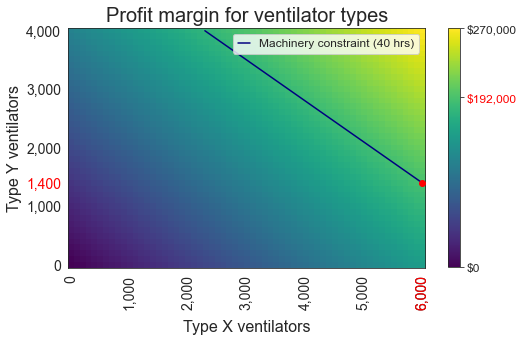

In [9]:
# visualize optimal solution
sns.set_style("white")

plt.figure(figsize=(8, 8))
cax = plt.imshow(profit_matrix, origin='lower', cmap='viridis')

plt.xlabel('Type X ventilators', fontsize=16, labelpad=10)
plt.xticks(np.linspace(0, 60, 7), np.linspace(0, 6000, 7).astype(int), rotation=90)
plt.xticks(list(plt.xticks()[0])+[optimal_type_x/100],fontsize=14)
plt.gca().axes.set_xticklabels(['0', '1,000', '2,000', '3,000', '4,000', '5,000', '6,000', '{:,}'.format(optimal_type_x)])
plt.gca().axes.get_xticklabels()[7].set_color("red")

plt.ylabel('Type Y ventilators', fontsize=16)
plt.yticks(np.linspace(0, 40, 5), np.linspace(0, 4000, 5).astype(int))
plt.yticks(list(plt.yticks()[0])+[optimal_type_y/100],fontsize=14)
plt.gca().axes.set_yticklabels(['0', '1,000', '2,000', '3,000', '4,000', '{:,}'.format(optimal_type_y)])
plt.gca().axes.get_yticklabels()[5].set_color("red")

y = np.array([14, 40])
plt.plot(200 * (0.4 - ((1/140)*y)), y, c='navy',label='Machinery constraint (40 hrs)')
plt.scatter(optimal_type_x/100, optimal_type_y/100, c='red', zorder=10)

cbar=plt.colorbar(cax, shrink=0.55, ticks=[0, optimal_profit, 270000])
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticklabels(['$0', '$'+'{:,}'.format(optimal_profit), '$270,000'])
cbar.ax.get_yticklabels()[1].set_color("red")

plt.title("Profit margin for ventilator types", fontsize=20)
do_not_print = plt.legend(loc='upper right',fontsize='12',handlelength=1)

In [10]:
# what-if analysis 
# what if we increase the number of available machinery hours?

obj = [-25, -30]

# three constraints
# maximum of 6,000 type X ventilators weekly
# maximum of 4,000 type Y ventilators weekly
# documented constraint was 40 hours per week - 
    # 200 type X ventilators per hour
    # 140 type Y ventilators per hour
    
min_machinery_hours = 40
    
lhs_ineq = [[1.0, 0.0],
            [0.0, 1.0],
            [1/200, 1/140]]

rhs_ineq = [6000,
           4000,
           min_machinery_hours]

max_profit = 0
optimal_result = None

for machinery_hours in range(min_machinery_hours, 100):
    rhs_ineq[2] = machinery_hours
    
    opt = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq)
        
    profit = abs(round(opt.fun))
    if profit > max_profit:
        max_profit = profit
        min_machinery_hours = machinery_hours
        optimal_result = opt

In [11]:
print('Machinery hours: '+str(min_machinery_hours))
do_not_print = display_solution(optimal_result)

Machinery hours: 59
Optimal profit: $270,000
Type X ventilators: 6,000
Type Y ventilators: 4,000

Type X slack: 0 ventilators
Type Y slack: 0 ventilators
Machinery slack: 0.4 hours


In [12]:
# since ventilators can only be manufactured in whole numbers
# we confirm our findings using integer programming
prob = pl.LpProblem('Capstone', pl.LpMaximize)

type_x = pl.LpVariable('type_x', 0, 6000,  pl.LpInteger)
type_y = pl.LpVariable('type_y', 0, 4000,  pl.LpInteger)

prob += 25 * type_x + 30 * type_y, "obj"

prob += 1/200 * type_x + 1/140 * type_y <= 40, "machinery"

prob

Capstone:
MAXIMIZE
25*type_x + 30*type_y + 0
SUBJECT TO
machinery: 0.005 type_x + 0.00714285714286 type_y <= 40

VARIABLES
0 <= type_x <= 6000 Integer
0 <= type_y <= 4000 Integer

In [13]:
pl.PULP_CBC_CMD().solve(prob)

for v in prob.variables():
    print(v.name, ': ', round(v.varValue))

print('Profit: $', pl.value(prob.objective))

type_x :  6000
type_y :  1400
Profit: $ 192000.0


In [14]:
# and finally, we verify our findings with the increase in machine resource
prob = pl.LpProblem('Capstone', pl.LpMaximize)

type_x = pl.LpVariable('type_x', 0, 6000,  pl.LpInteger)
type_y = pl.LpVariable('type_y', 0, 4000,  pl.LpInteger)

prob += 25 * type_x + 30 * type_y, "obj"

prob += 1/200 * type_x + 1/140 * type_y <= 58.6, "machinery"

pl.PULP_CBC_CMD().solve(prob)

for v in prob.variables():
    print(v.name, ': ', round(v.varValue))

print('Profit: $', pl.value(prob.objective))

type_x :  6000
type_y :  4000
Profit: $ 270000.0
